# implements the WR (Weather Regime) class

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import warnings

In [3]:
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [4]:
import os
import json
import numpy as np
import pandas as pd

In [5]:
import sys
sys.path.append('/Users/nicolasf/CODE/paleopy/')

In [6]:
from paleopy.core.proxy import proxy
from paleopy.core.composite import composite
from paleopy.plotting.scalar_plot import scalar_plot

In [7]:
proxies_num = pd.read_excel('./data/ProxiesLIANZSWP.xlsx', sheetname='numerical')

In [8]:
row = proxies_num.iloc[0,]

In [9]:
p = proxy(row.Site, row.Long, row.Lat, row.dataset, row.variable, 'DJF', value = row.Anom, \
          calc_anoms=True, detrend=True)

In [10]:
p.season

'DJF'

In [11]:
# extract the time-series
p.extract_ts()

print("{}{} --> {}{}: {} km".format(p.sitename, p.coords, p.variable, p.extracted_coords.tolist(), p.distance_point))

# calculates the season
p.calculate_season()

p.find_analogs()

Rarotonga(200.18000000000001, -21.23) --> sst[200.0, -22.0]: 87.56368858840081 km


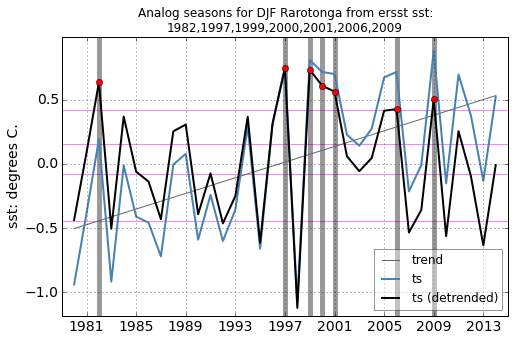

In [12]:
f = p.plot_season_ts()

In [13]:
%%writefile /Users/nicolasf/CODE/paleopy/paleopy/core/WR.py

import os
import sys
import numpy as np
import pandas as pd
import h5py
import json

from ..markov import *
from ..utils import seasons_params

class WR:

    """
    base class for weather regimes calculations and plots
    takes either a proxy or ensemble instance and either 'SW Pacific Regimes' or 'Kidson Types'
    """
    def __init__(self, obj, json_file='./jsons/WRs.json', classification='Kidson Types'):
        super(WR, self).__init__()
              
        # the parent can be either an instance of a `proxy` or `ensemble` class
        self.parent = obj
        
        self.json_file = json_file 
        self.classification = classification
        
        # get the season, and the analog years
        self.season = self.parent.season
        self.analog_years = self.parent.analog_years
        self.detrend = self.parent.detrend
        self.climatology = self.parent.climatology
        
    def _get_WR_json(self): 
        with open(self.json_file, 'r') as f:
            dict_json = json.loads(f.read())
        return dict_json
            
    def _get_WR_ts(self): 
        if not(hasattr(self, 'dict_json')): 
            self.dict_json = self._get_WR_json()
        csv = self.dict_json[self.classification]['WR_TS']
        wr_ts = pd.read_csv(csv, parse_dates=True, index_col=0)
        return wr_ts
    
    def _get_WR_MC(self): 
        if not(hasattr(self, 'dict_json')): 
            self.dict_json = self._get_WR_json()
        f = h5py.File(self.dict_json[self.classification]['Markov Chains'], mode='r')
        MC_probs = f[self.season]['probs'].value
        MC_probs_classes = f[self.season]['probs'].attrs['classes']
        f.close()
        MC_probs_classes = MC_probs_classes.split(',')
        MC_probs = pd.DataFrame(MC_probs, index=MC_probs_classes)
        MC_probs = MC_probs.reindex(self.dict_json[self.classification]['types'])
        # The MC_probs contains the frequencies 
        # of each type in the 1000 simulations
        self.MC_probs = MC_probs
        return self
        
    def _get_season_ts(self): 
        if not(hasattr(self,'wr_ts')): 
            wr_ts = self._get_WR_ts()
        ts = wr_ts.copy()
        ts.loc[:,'month'] = ts.index.month

        sparams = seasons_params.seasons_params()
        m = list(range(1,13)) + list(range(1,13))
        m = m[(sparams[self.season][1]-sparams[self.season][0]+12):(sparams[self.season][1]+12)]

        # selects the season
        ts_seas = ts[ts['month'].isin(m)]
        ts_seas = ts_seas.drop('month', axis=1)
        
        return ts_seas
    
    def _get_clim_probs(self): 
        if not(hasattr(self, 'ts_seas')): 
            ts_seas = self._get_season_ts()
        ts = ts_seas.ix[str(self.climatology[0]): str(self.climatology[1])].copy()
        types = self.dict_json[self.classification]['types']
        clim_probs = get_probs(ts['type'], types)
        clim_probs = pd.Series(clim_probs, index=types)
        return clim_probs
        
    def _get_compos_probs(self): 
        if not(hasattr(self, 'ts_seas')): 
            ts_seas = self._get_season_ts()
        ayears = list(map(str, self.analog_years))
        ts = ts_seas.copy()
        ts = pd.concat([ts.ix[l] for l in ayears])
        types = self.dict_json[self.classification]['types']
        obs_probs = get_probs(ts['type'], types)
        obs_probs = pd.Series(obs_probs, index=types)
        return obs_probs
    
    def probs_anomalies(self): 
        pass
        

Overwriting /Users/nicolasf/CODE/paleopy/paleopy/core/WR.py


In [14]:
from paleopy.core.WR import WR

In [15]:
w = WR(p)

In [16]:
w = w._get_WR_MC()

In [17]:
np.percentile(w.MC_probs.T, 0.98)

0.029423003439052346

In [18]:
w.MC_probs.T.quantile(0.02)

T      0.093237
SW     0.082530
TNW    0.077188
TSW    0.057318
H      0.064196
HNW    0.036293
W      0.026366
HSE    0.147489
HE     0.049675
NE     0.066870
HW     0.064578
R      0.054643
dtype: float64

In [24]:
obs_probs = w._get_compos_probs()
clim_probs = w._get_clim_probs()

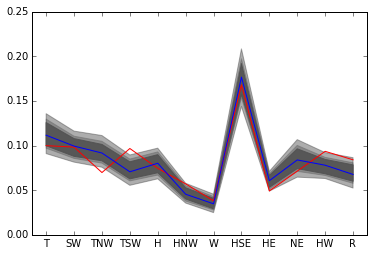

In [25]:
f, ax = plt.subplots()
# ax.plot(w.MC_probs.T.quantile(0.05))
# ax.plot(w.MC_probs.T.quantile(0.95))
ax.fill_between(range(12), w.MC_probs.T.quantile(0.1), w.MC_probs.T.quantile(0.9), color='0.1', alpha=0.9)
ax.fill_between(range(12), w.MC_probs.T.quantile(0.05), w.MC_probs.T.quantile(0.95), color='0.6', alpha=0.6)
ax.fill_between(range(12), w.MC_probs.T.quantile(0.01), w.MC_probs.T.quantile(0.99), color='0.2', alpha=0.4)

ax.plot(obs_probs, color='r')
ax.plot(clim_probs, color='b')


ax.set_xlim(-0.5, 11.5)
ax.set_xticks(range(12))
ax.set_xticklabels(w.dict_json[w.classification]['types']); 

In [26]:
obs_probs

T      0.099842
SW     0.098257
TNW    0.069731
TSW    0.096672
H      0.074485
HNW    0.057052
W      0.038035
HSE    0.167987
HE     0.049128
NE     0.071315
HW     0.093502
R      0.083994
dtype: float64

In [27]:
clim_probs

T      0.111563
SW     0.099372
TNW    0.091614
TSW    0.070558
H      0.080163
HNW    0.045438
W      0.034725
HSE    0.176579
HE     0.060584
NE     0.083857
HW     0.077946
R      0.067603
dtype: float64

In [28]:
obs_probs - clim_probs

T     -0.011721
SW    -0.001115
TNW   -0.021884
TSW    0.026114
H     -0.005678
HNW    0.011615
W      0.003310
HSE   -0.008592
HE    -0.011455
NE    -0.012541
HW     0.015556
R      0.016391
dtype: float64